# Using Machine Learning to predict certain crimes like Motor Vehicle Theft

### Part 1: Introduction and the data set

Large datasets provide the advantage of exploring trends, correlations and patterns. Utilizing machine learning allows analysts and decision makers to go beyond human intuition and regular data analysis.

British economist Ronald Coase once said, "If you torture the data long enough, it will confess to anything." It's critical to know how to correctly handle and wrangle our data so that it doesn't give us incorrect results that align with our previously held biases or are just entirely incorrect. Knowing what methods to use and what methods to avoid is just as important as being able to run the code that makes up Machine Learning and other Artificial intelligence algorithms. 

For this project I will try to use XGBoost and a large dataset to predict a specific type of crime (car jackings) based on the information that comes in when reported. Labeled as "The King of Machine Learning Algorithms" (https://medium.com/latinxinai/xgboost-the-king-of-machine-learning-algorithms-6b5c0d4acd87) by some, XGBoost is used across a variety of industries and has performed extremely well at Machine Learning Competitions.   
    
The motivation behind this project is multifaceted. Being able to leverage data to predict crimes has various benefits. Various industries such as law enforcement, insurance, and real estate have a stake in knowing when and where car jackings will happen. Additionally, I think exploring topics just to know is important. The curious side of me is also just interested in seeing what the relationship between all these variables is. Knowing just to know. Solving problems for the sake of solving problems. 

In [1]:
import pandas as pd
from datetime import datetime
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Data was taken from a Chicago Crime Data Base 
ChicagoCrime_df = pd.read_csv("ChicagoCrime.csv")

Link to data: https://data.cityofchicago.org/Public-Safety/Crimes-2024/dqcy-ctma/about_data

The data comes from the City of Chicago data portal. 

In [3]:
ChicagoCrime_df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,13663524,JH507759,11/12/2024 0:00,080XX S INGLESIDE AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,APARTMENT,False,False,...,8,44.0,11,1183958.0,1851936.0,2024,11/19/2024 15:40,41.748890,-87.601479,POINT (-87.601479486 41.748890402)
1,13660961,JH504722,11/12/2024 0:00,081XX S DAMEN AVE,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,...,17,71.0,14,1164440.0,1850774.0,2024,11/19/2024 15:40,41.746135,-87.673033,POINT (-87.673033382 41.74613501)
2,13661941,JH505855,11/12/2024 0:00,067XX S RACINE AVE,1240,DECEPTIVE PRACTICE,UNLAWFUL USE OF A COMPUTER,RESIDENCE,False,False,...,17,67.0,11,1169483.0,1860039.0,2024,11/19/2024 15:40,41.771452,-87.654287,POINT (-87.654286742 41.771451704)
3,13662947,JH506460,11/12/2024 0:00,070XX W NEWPORT AVE,710,THEFT,THEFT FROM MOTOR VEHICLE,STREET,False,False,...,38,17.0,6,1128844.0,1922130.0,2024,11/19/2024 15:40,41.942623,-87.801850,POINT (-87.801849533 41.942623178)
4,13661778,JH505700,11/12/2024 0:00,022XX N ELSTON AVE,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,...,32,22.0,14,1163656.0,1915119.0,2024,11/19/2024 15:40,41.922721,-87.674097,POINT (-87.674096681 41.922720997)


### Part 2: Data Wrangling

Our data set has plenty of useful variables that can't be used by XGBoost. The "Date" Column will need to be transformed into several different variables such as "Month", "Day of Week" or "WeekDay" and "hour". XGBoost can't parse categorical variables, so we'll need to turn any useful variables like "location description" into usable numerical values. Additional changes to future iterations include adding in certain information about each zip code will be valuable as well. For example, each zip codes historical crime rates and zoning.

In [4]:
#Adding in the Month column using the already existing Date column 
ChicagoCrime_df["Month"] = ChicagoCrime_df['Date'].str.split('/').str[0]

In [5]:
def get_day_of_week(date_str):
    """
    Converts a date string into the day of the week.

    Args:
        date_str (str): Date string in the format 'MM/DD/YYYY' or similar.
        
    Returns:
        str: Day of the week abbreviation ('mon', 'tues', etc).
    """
    # Parse the input date string
    date_obj = datetime.strptime(date_str, '%m/%d/%Y')
    
    # Get the day of the week and return the abbreviation
    return date_obj.strftime('%a').lower()

In [6]:
#Using the "get_day_of_week" function to convert the Date column to be a day of the week abbreviation

#Prepare variable to be used by function 
ChicagoCrime_df['WeekDay'] = ChicagoCrime_df['Date'].str.split(' ').str[0]

#Apply function 
ChicagoCrime_df['WeekDay'] = ChicagoCrime_df['WeekDay'].apply(lambda x: get_day_of_week(x))

In [7]:
ChicagoCrime_df['WeekDay'][:6]

0    tue
1    tue
2    tue
3    tue
4    tue
5    tue
Name: WeekDay, dtype: object

In [8]:
def weekday_to_numeric(day):
    """
    Converts a weekday name ('mon', 'tue', 'wed', etc.) to a numeric value (0, 1, 2, etc.).
    
    Args:
        day (str): Weekday name as a string ('mon', 'tue', 'wed', etc.).
        
    Returns:
        int: Corresponding numeric value (0 for 'mon', 1 for 'tue', etc.).
    """
    # Dictionary mapping weekdays to numbers
    weekday_map = {
        'mon': 0,
        'tue': 1,
        'wed': 2,
        'thu': 3,
        'fri': 4,
        'sat': 5,
        'sun': 6
    }
    
    # Return the corresponding numeric value or raise an error if invalid day
    return weekday_map.get(day.lower(), -1)  # Returns -1 if the input is invalid

In [9]:
#Converting the "WeekDay" variable to be a numerical value 
ChicagoCrime_df['WeekDay'] = ChicagoCrime_df['WeekDay'].apply(lambda x: weekday_to_numeric(x))

Some crimes may be more likely to happen at certain times of the day. Creating a separate variable that lists the hour an incident takes place at may be able to provide useful information for our model. 

In [10]:
ChicagoCrime_df["Hour"] = ChicagoCrime_df['Date'].str.split(' ').str[1].str.split(":").str[0].astype(float)

The cover of night/darkness may correlate to the frequency of certain crimes. Because the sunset and sunrise changes based on the time of the year, another data with Chicago sunset and sunrise information will be merged to our crime data. 

The ChicagoNights.csv is a customized data set from a larger dataset that can be found at: https://www.timeanddate.com/sun/usa/chicago. It gives each relevant day of the year (up to November 30th as the crime data set does not include December 2024) and at what time the night ends and starts.  

In [11]:
ChicagoNights_df = pd.read_csv("ChicagoNights.csv")

In [12]:
ChicagoNights_df.head(4)

,Date,Month,Day,End of Night,Start of Night
0,1,January,1/1/2024,1/1/2024 6:11,1/1/2024 17:36
1,2,January,1/2/2024,1/2/2024 6:11,1/2/2024 17:37
2,3,January,1/3/2024,1/3/2024 6:11,1/3/2024 17:38
3,4,January,1/4/2024,1/4/2024 6:12,1/4/2024 17:38


The ChicagoCrimes "Date" variable needs to be modified so it can merge with the ChicagoNights "Day" variable.

In [13]:
#Takes off the time component of the date/time variable
ChicagoCrime_df['Day'] = ChicagoCrime_df['Date'].str.split(' ').str[0]

In [14]:
#Merging the data sets
ChicagoCrime_df = pd.merge(ChicagoCrime_df, ChicagoNights_df, on='Day', how='left')

Creating a new variable called "Night" that looks at whether or not the time of the incident occurs either before the end of night or after the start of night on a certain day. 

In [15]:
ChicagoCrime_df["Night"] = (pd.to_datetime(ChicagoCrime_df["Date_x"]) <= pd.to_datetime(ChicagoCrime_df["End of Night"])) | (pd.to_datetime(ChicagoCrime_df["Date_x"]) >= pd.to_datetime(ChicagoCrime_df["Start of Night"])) 

The location variable gives insight into the location of the reported incident. There are currently 127 different locations in the dataset. Some of these locations like "STREET" or "APARTMENT" are incredibly common and should be converted to categorical variables to give our model more information. However, adding binary variables for all 127 location types would introduce many sparse features, which would increase noise and reduce model efficiency. Instead, I focused on the most frequent locations (over 10,000 incidents each). To identify the most common locations, I counted the frequency of each unique location description. 

In [16]:
#Creating a dictionary that counts all the different instances of when each variable is used
Loc_dict = dict()
for j in ChicagoCrime_df['Location Description']:
    if j not in Loc_dict.keys():
        Loc_dict[j] = 1
    else: 
        Loc_dict[j] +=1

In [46]:
#Sorting the Dictionary in Sorting Value
Loc_dict_sorted =sorted(Loc_dict.items(), key=lambda x: x[1], reverse = True)

#Only 4 Location Descriptions Occur Over 10,000 times
Loc_dict_sorted[:4]

[('STREET', 61302),
 ('APARTMENT', 41986),
 ('RESIDENCE', 26251),
 ('SIDEWALK', 12361)]

In [18]:
#Creating a boolean column for each of the most common location types

ChicagoCrime_df["Street Location"] = ChicagoCrime_df["Location Description"] == "STREET"
ChicagoCrime_df["Apartment Location"] = ChicagoCrime_df["Location Description"] == "APARTMENT"
ChicagoCrime_df["Residence Location"] = ChicagoCrime_df["Location Description"] == "RESIDENCE"
ChicagoCrime_df["Sidewalk Location"] = ChicagoCrime_df["Location Description"] == "SIDEWALK"

We'll create a Data Frame that includes only our relevant variables. Certain variables, such as incident codes or text descriptions, are highly detailed and not easily usable in a predictive model without advanced preprocessing. For this iteration, I excluded them but noted for potential future exploration. 

I prepared the dataset for modeling by ensuring categorical and non-numerical variables were properly converted into numerical formats. 

In [19]:
Crime_Variables = ChicagoCrime_df[["Ward","Month_x","WeekDay", "Hour", "Night", "Street Location", "Apartment Location",'Residence Location', 'Sidewalk Location', 'Primary Type']].copy()

In [20]:
Crime_Variables.head(5)

,Ward,Month_x,WeekDay,Hour,Night,Street Location,Apartment Location,Residence Location,Sidewalk Location,Primary Type
0,8,11,1,0.0,True,False,True,False,False,DECEPTIVE PRACTICE
1,17,11,1,0.0,True,True,False,False,False,CRIMINAL DAMAGE
2,17,11,1,0.0,True,False,False,True,False,DECEPTIVE PRACTICE
3,38,11,1,0.0,True,True,False,False,False,THEFT
4,32,11,1,0.0,True,True,False,False,False,CRIMINAL DAMAGE


We still need to make sure these variables are in the right format. For example the month variable (which got it's name changed to "month_x" during the merge) is not in either float or integer format. So that will need to be changed. 

In [21]:
#Crime_Variables['Month'] = Crime_Variables['Month_x'].astype('int')
Crime_Variables.loc[:, "Month"] = Crime_Variables['Month_x'].astype('int')

The primary type variable needs to be converted to a boolean variable that is TRUE when the Primary Type is "Motor Vehicle Theft" and FALSE for every other incident type/crime. Note that "MVT" stands for Motor Vehicle Theft. 

In [22]:
Crime_Variables["MVT"] = Crime_Variables["Primary Type"] == "MOTOR VEHICLE THEFT"

In [23]:
#Dropping the "Primary Type" variable as it is not longer necessary 
Crime_Variables = Crime_Variables.drop(["Month_x", "Primary Type"], axis = 1)

In [24]:
pct_of_MVTs = round(sum(Crime_Variables["MVT"])/len(Crime_Variables)*100,2)

f"Only {pct_of_MVTs}% of the dataset is a Motor Vehicle Theft"

'Only 8.55% of the dataset is a Motor Vehicle Theft'

Although Motor Vehicle Theft makes up only 8.55% of the dataset, XGBoost is good at handling inbalanced data sets. 

In [25]:
# Convert boolean target to binary
Crime_Variables['MVT'] = Crime_Variables['MVT'].astype(int)  

## Part 3: The Model

With a clean dataset prepared, the next step is to build and evaluate a predictive model. 

In [26]:
# Split the data into features (X) and target (y)
X = Crime_Variables.drop(columns=['MVT'])
y = Crime_Variables['MVT']

In [27]:
# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
# Convert to DMatrix
train_dmatrix = xgb.DMatrix(data=X_train, label=y_train)
test_dmatrix = xgb.DMatrix(data=X_test, label=y_test)

In [29]:
# Define parameters for binary classification
params = {
    'objective': 'binary:logistic',  # Binary classification
    'eval_metric': 'logloss',       # Log-loss
    'eta': 0.2,                     # Learning rate
    'max_depth': 4                 # Maximum tree depth
}

Our XGBoost model does need some parameters that we need to choose. 

1. "objective: binary:logistic" 
>a. We'll use logistic regression to output the probability of whether or not a motor vehicle theft is occuring. 

2. "eval_metric: logloss"
>a. All Machine Learning algorithms need a way to define the distance between its predictions and the actual values it's trying to predict. The logloss evaluation metric is the standard for binary classification problems like ours, especially for an inbalanced data set like ours. 
    
 
    
3. "eta" 0.2     
>a. Eta indicates the learning rate. A smaller learning rate (than the default of 0.3) means that we want our model to update weights more gradually, reducing the risk of overfitting which creates a more generalizable model 
    
4. "Max_depth: 4" 
>a. XGBoost is ultimately a decision tree. Max_depth sets a limit on the number of splits a tree can go from root to deepest node. The default value for this parameter is 6. A smaller max_depth value decreases overfitting and attempts to restrict the massive consumption of memory invovled with XGBoost. 

In [30]:
# Train the XGBoost model
bst = xgb.train(params, train_dmatrix, num_boost_round=100)

In [31]:
# Make predictions (probabilities for the positive class)
pred_probs = bst.predict(test_dmatrix)

Inspecting the distribution of predicted probabilities provides insight into model behavior and potential threshold selection. Sometimes the distribution will tell us some thing either interesting about the model itself or the data we are working with. 

In [32]:
#Function that shows the distribution of a data set
def show_distribution_sns(data, title="Data Distribution"):
    """
    Shows the distribution of data using a histogram and kernel density estimate.

    Args:
        data (list or numpy.ndarray): The data to be plotted.
        title (str, optional): The title of the plot. Defaults to "Data Distribution".
    """
    sns.displot(data, kde=True,  height=5, aspect=2)
    plt.title(title)
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.show()

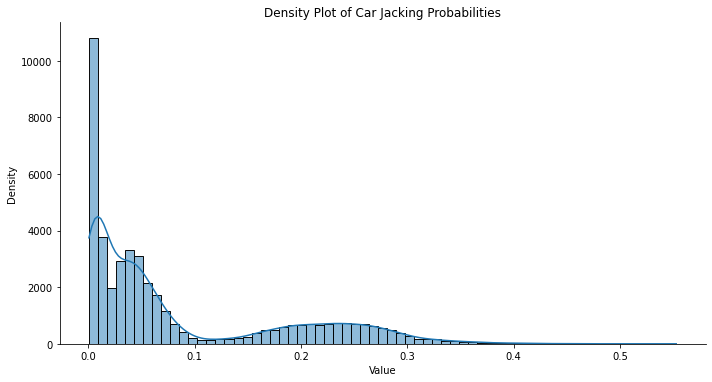

In [33]:
show_distribution_sns(pred_probs, title = "Density Plot of Car Jacking Probabilities")

I think this is an interesting distribution! There is one group of predictions that are clustered around 0 and then there is a second group of predictions (around the 0.1 - 0.4) area that has a higher distribution probability of car jacking. This could indicate that our data has a bimodal distribution-- two distinct groups of data (in this case car jackings and not car jackings) in one data set. This tells us a lot of good information. It tells us that our model is headed in the right direction and that our data can likely be used to predict the likelihood of crime incidents.

This distribution may also tell us where to set a good threshold for identifying a car jacking. In practice, theshold selection depends on the relatvie cost of false positives and false negatives. For example, law enforcement may prefer a lower threshold to avoid potential incidents, even at the cost of additional false alarms. 

From our distribution, we can see that a good threshold to set may be 11% (or .11). This 11% may be where the distribution of active carjackings may occur. This threshold can be changed to accomodate for officer placement and resource allocation. Thresholds can be dynamically adjusted based on resource availability and proximity. 

In [34]:
# Convert probabilities to binary predictions
threshold = 0.12
preds = (pred_probs >= threshold).astype(int)

In [35]:
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, preds))
print("\nClassification Report:\n", classification_report(y_test, preds))

Accuracy: 0.7639411411144008

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.77      0.86     41080
           1       0.23      0.74      0.35      3841

    accuracy                           0.76     44921
   macro avg       0.60      0.75      0.60     44921
weighted avg       0.91      0.76      0.81     44921



## Part 4: Analysis and Next Steps

### Analysis

When it comes to grading models there are multiple different metrics we can use that are shown above. 

Precision is a measure of what percent of our predicted car jackings were actually car jackings. With a score of 0.23 or 23%, that seems quite low. While it seems quite low, this is not the best metric for measuring our model's ability. In my opinion trying to predict things like car jackings you'll want to be overly cautious. In practice, having a large number of false alarms may be too costly. The model should also track how many actual car jackings take place that the model doesn't report. 

This is what recall tracks. With a recall score of 0.77, this indicates that 77% of actual car jackings were identified as such by the model. This is a good start for a first iteration of a model, but we'll want to apply more and more variables to add more predictive power to our model. 

F1 score is the another metric that's shown in the table above. F1 score is the harmonic mean between the precision and recall. Our F1 score is relatively low. However, this shouldn't worry us. F1 scores should be carefully interpreted in imbalanced datasets and aren't the best. 8% of our data set was Motor Vehicle Thefts (not very class-balanced). So we should focus on the Weighted-Average F1 score, which takes into account the imbalance between classes. A weighted-average F1 score of 0.81 is much better than 0.35 and a sign that our model is on the right path.  

### Next Steps

A future iteration of this project should include more exploratory data analysis. Looking at correlations between certain variables could help us to shed light on our dataset and better inform how we structure the model. 

In an attempt to improve the model, I ran a Hyperparameter tuning grid search. Unfortunately, this process takes a very long time and with more time and computing power it can be done. In future iterations, if I acquire a better computer this could add a fair amount of predictability to the model.  

Our next steps should be to add in additional variables. Currently our only geographic variable was Ward. Chicago currently has 50 wards which may not be enough to adequately divide up the city into distinct geographic divisions. There are latitude and longitude information that we could add into the model that could help provide information about where certain crimes typically occur by combining these points with zip codes or clustering them together.  

Similar to how we merged in a separate data frame about the start and end of nighttime in Chicago, adding in a data frame that had specific historical crime data about each zip code/street block would be extremely useful in predicting crime. Other demographic stats like average age or median household income of a zip code may be able to provide useful information to our model.  

Once our model for car jacking is refined, we should apply the methodology used here to other crimes like arson, burglary, or homicide.